# 1. Set up data & model #

In [1]:
import keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from classification_models.classification_models.keras import Classifiers
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
chosenModel, preprocess_input = Classifiers.get('resnet34')

In [3]:
base_model = chosenModel(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])
# model.save_weights("ckpt")
# model.load_weights("ckpt")

In [4]:
def load_data(folder_name, img_size):
    data = []
    
    for filename in os.listdir(folder_name):
        f = os.path.join(folder_name, filename)
        im = Image.open(f)
        im = im.convert('RGB')
        im = im.resize((img_size, img_size))
        x = np.array(im)
        x = preprocess_input(x)
        y = filename[filename.find('_') + 1]
        data.append((x, float(y)))
                    
    return data

In [5]:
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

# 2. Training #

Train the model

In [6]:
path = '../Dataset/Classification'
# path = 'small_sample_dataset'
img_size = 224

In [7]:
# data = load_data(path, img_size)
data_neg = load_data(path + '/0', img_size) + load_data(path + '/selected_0', img_size)
data_pos = load_data(path + '/1', img_size)

In [8]:
data_pos1 = data_pos
data = data_neg + data_pos1
random.shuffle(data)
print('# negative images', len(data_neg))
print('# postive images', len(data_pos1))
print('# total', len(data))

# negative images 16140
# postive images 5380
# total 21520


label:  1.0


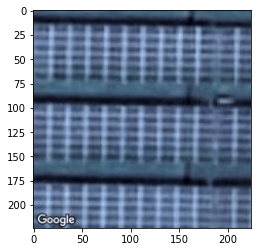

In [9]:
i = random.randint(0, len(data))
print('label: ', data[i][1])
plt.imshow(data[i][0])

In [10]:
LR = 0.0001
OPTIMIZER = keras.optimizers.Adam(LR)
LOSS = tf.keras.losses.BinaryCrossentropy()
METRICS = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
EPOCHS = 2
BATCH_SIZE = 32

In [11]:
split1 = int(0.9 * 21520)
split2 = int(0.95 * 21520)
train = data[:split1]
val = data[split1:split2]
test = data[split2:]

train_dataloader = Dataloader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(val, batch_size=1, shuffle=False)

In [12]:
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
# history = model.fit(X, Y, batch_size=batch_size, epochs=epochs)
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    shuffle = True,
    epochs=EPOCHS, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/2
605/605 [==============================] - 285s 459ms/step - loss: 0.0926 - binary_accuracy: 0.9707 - precision: 0.9600 - recall: 0.9220 - val_loss: 0.0576 - val_binary_accuracy: 0.9814 - val_precision: 0.9684 - val_recall: 0.9533
Epoch 2/2
605/605 [==============================] - 273s 452ms/step - loss: 0.0224 - binary_accuracy: 0.9928 - precision: 0.9884 - recall: 0.9830 - val_loss: 0.0615 - val_binary_accuracy: 0.9861 - val_precision: 0.9840 - val_recall: 0.9572


Plot training details

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
test_dataloader = Dataloader(test, batch_size=1, shuffle=False)

scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.4}".format(scores[0]))
for metric, value in zip(METRICS, scores[1:]):
    print("mean {}: {:.4}".format(metric, value))

/tmp/ipykernel_16633/1217358558.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.05883
mean BinaryAccuracy(name=binary_accuracy,dtype=float32,threshold=0.5): 0.987
mean Precision(name=precision,dtype=float32,thresholds=None,top_k=None,class_id=None): 0.9837
mean Recall(name=recall,dtype=float32,thresholds=None,top_k=None,class_id=None): 0.9602
